In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#@author: Kelle Clark, Andrew Florian, Xinyu Xiong
#Created on Tue Feb  4 10:05:49 2020
#CSCI 6040 Project 1 Text Generation
#PHASE 3: Smoothing the Language Models for the Corpus

#Various folders of .txt files were created in the CSCI6040 Team Project 1 folder
#to be used for testing our application during develpment
#/Short Test Data
# has 3 .txt files each about 4KB
#/Med test Data 
# has 2 .txt files one of 119KB (Tragedy of Macbeth) and 6.5MB (big)
#/Grande test Data (the 18-document-gutenburg-copus but with 19? files cleaned using the 
#boilerplate.ipynb -author Andrew Florian and resulting files 
#shared on Canvas in Project 1 discussion forum)
# has 19 .txt files with a total of 11.8MB

In [2]:
#we needed the help of a few packages...import all those at once
import langid
import itertools 
import nltk
import numpy
import os
import pandas
import random
import re
import string
import sys
from collections import Counter
from math import log10
from matplotlib.pyplot import yscale, xscale, title, plot,legend
from matplotlib.legend_handler import HandlerLine2D
from nltk.tokenize import word_tokenize, sent_tokenize

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM
#from keras.utils import np_utils
#from keras.callbacks import ModelCheckpoint


In [3]:
#**** from phase 1 reading in the tokenized corpus

def tokensByFiles(folderpath):
    textfiles = [f for f in os.listdir(folderpath) if '.txt' in f]
    tokenfilelist =[]
    tokens = []
    file_string = []
    for f in textfiles:
        i = 0
        substring = '' 
        rawcorpus = []            
        file = open(folderpath+"/"+f,'rt', encoding='utf-8', errors='replace')                                   
        #print (f"     Reading from: '{f}' . . .")
        original_string = file.read()
        new_string = re.sub('[^a-zA-Z]', ' ', original_string)            
        file.close()
        substring = substring + ' ' + new_string
        file_string.append(substring)
        file_tokens = word_tokenize(substring)
        file_tokens = [w.lower() for w in file_tokens]
        tokenfilelist.append(file_tokens)
        tokens = tokens + file_tokens         
    return (tokens,tokenfilelist, file_string)

#ngrams returns a dictionary
# enumerate ngrams code copied from Eisentein and CSCI6040 ipynb
# returns the ngram from instring and n
def ngrams(instring, n):
    outset = {}
    for i in range(len(instring) - n + 1):
        g = ' '.join(instring[i:i+n])
        outset.setdefault(g, 0)
        outset[g] += 1
    return outset        


In [4]:
#**** from phase 1 reading in the .txt files and creating the tokenized corpus
print("start read test data")
pathname_test = 'Data/test data'
#read in the corups file by file
(tokens_test,tokenfilelist_test, file_string_test) = tokensByFiles(pathname_test)
print(f"token_test_length: {len(tokens_test)}, tokenfilelist_test_length: {len(tokenfilelist_test)}")
print("start read training data")
pathname_training = 'Data/training data'
#read in the corups file by file
(tokens_training,tokenfilelist_training, file_string_training) = tokensByFiles(pathname_training)
print(f"token_training_length: {len(tokens_training)}, tokenfilelist_training_length: {len(tokenfilelist_training)}")

start read test data
token_test_length: 2135605, tokenfilelist_test_length: 18
start read training data
token_training_length: 2058838, tokenfilelist_training_length: 463


In [5]:
def getbigword(COUNT):
    greatestprob = 0
    bigword = ''
    for w in COUNT.keys():
        if COUNT[w] >= greatestprob:
            bigword = w
            greatestprob = COUNT[w]
    return bigword

In [6]:
def fig(n,bigword_test,bigword_training,bigword_all,test,training,alldata):
    yscale('log'); xscale('log'); title(f'Frequency of n-th most frequent {n}-itemset and 1/n line.')
    M_test = test[bigword_test]
    M_training = training[bigword_training]
    M_all = alldata[bigword_all]
    plot([c for (w,c) in test.most_common()],label = "prob test data")
    plot([(M_test)/i for i in range(1, len(test)+1)], label = f"M/i test data \"{bigword_test}\"");
    plot([c for (w,c) in training.most_common()], label = "prob training data")
    plot([(M_training)/i for i in range(1, len(training)+1)], label= f"M/i training data \"{bigword_training}\"");
    plot([(M_all)/i for i in range(1, len(alldata)+1)], label = f"M/i all data \"{bigword_all}\"");
    legend(loc="best")

The sum of all the probabiities of unigrams needs to be 1 and it is 1.0000000000003613

The sum of all the probabiities of unigrams needs to be 1 and it is 0.9999999999997059

Number of rows in Unigram Prob. Model Test:  41065
                 prob.
emma      4.055057e-04
by        3.982010e-03
jane      1.418802e-04
austen    1.404754e-06
volume    1.498404e-05
...                ...
endowing  4.682514e-07
delving   4.682514e-07
germinal  4.682514e-07
blither   4.682514e-07
ushering  4.682514e-07

[41065 rows x 1 columns]
Number of rows in Unigram Prob. Model Training:  36550
                     prob.
media         3.798259e-04
multiplexity  4.857109e-06
in            2.151019e-02
connectivist  3.302834e-05
moocs         4.240256e-04
...                    ...
takashi       4.857109e-07
mousetracker  4.857109e-07
aptel         4.857109e-07
systemics     4.857109e-07
jsci          4.857109e-07

[36550 rows x 1 columns]
the unigram of greatest freq is: the, the, the 



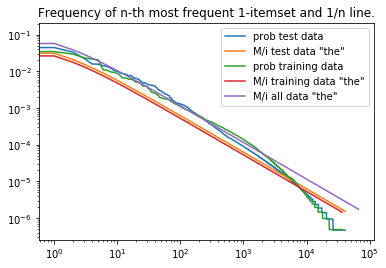

In [7]:
#**** from phase 2 creating the four different language models using ngrams:
#unigram prob. model using prob(x) = (frequency of x in corpus)/(total in corpus)
def createUnigramModel(instring):
    n = 1
    #outset = word_tokenize(instring)
    outset = instring
    totalpossible = len(outset)
    sumofprob = 0
    
    anoutcome = ngrams(outset,n)
    probmodel = anoutcome
  
    for keyword in anoutcome:
        probmodel[keyword] = (anoutcome[keyword]) / totalpossible
        sumofprob = sumofprob + probmodel[keyword]
    
    print(f"The sum of all the probabiities of unigrams needs to be 1 and it is {sumofprob}\n")
    return probmodel
 
#create the unigram model 
unigrammodel_test = createUnigramModel(tokens_test)
unigrammodel_training = createUnigramModel(tokens_training)


pandas.set_option("display.max_rows", 10)
unidataframe_test = pandas.DataFrame.from_dict(unigrammodel_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Unigram Prob. Model Test: ', len(unidataframe_test.index))
print(unidataframe_test)

pandas.set_option("display.max_rows", 10)
unidataframe_training = pandas.DataFrame.from_dict(unigrammodel_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Unigram Prob. Model Training: ', len(unidataframe_training.index))
print(unidataframe_training)
#Attempt to try and plot the unigram language model using first a Counter object
COUNT_test = Counter(unigrammodel_test)
bigword_test = getbigword(COUNT_test)
        
COUNT_training = Counter(unigrammodel_training)
bigword_training = getbigword(COUNT_training)

COUNT_total = COUNT_test + COUNT_training
bigword_total = getbigword(COUNT_total)

print(f"the unigram of greatest freq is: {bigword_test}, {bigword_training}, {bigword_total} \n")
fig(1,bigword_test,bigword_training,bigword_total, COUNT_test, COUNT_training,COUNT_total)

The sum of all the probabiities for bigrams needs to be 1 and it is 0.9999995317525886
The sum of all the probabiities for bigrams needs to be 1 and it is 0.9999995142851744
Number of rows in Bigram Prob. Model :  578067
                        prob.
emma by          9.365028e-07
by jane          1.873006e-06
jane austen      1.404754e-06
austen volume    4.682514e-07
volume i         4.682514e-07
...                       ...
really undoing   4.682514e-07
undoing turning  4.682514e-07
turning so       4.682514e-07
finally good     4.682514e-07
hail my          4.682514e-07

[578067 rows x 1 columns]
Number of rows in Bigram Prob. Model :  548110
                              prob.
media multiplexity     1.942843e-06
multiplexity in        4.857109e-07
in connectivist        9.228507e-06
connectivist moocs     7.285663e-06
moocs rafa             4.857109e-07
...                             ...
problems journal       4.857109e-07
on systemics           4.857109e-07
systemics cybernetics

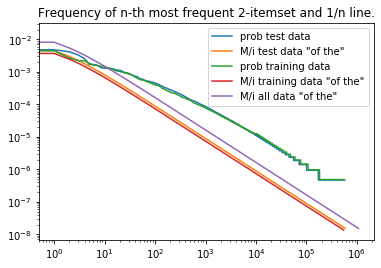

In [13]:
def createBigramModel(instring):
    n = 2
    outset = instring#word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,n)
    previousoutcome = ngrams(outset,n-1)
    sumofprob = 0
    
    probmodel = anoutcome
       
    for keyword in anoutcome:
        listword = keyword.split()
        prob1 = (previousoutcome[listword[0]]) / totalpossible
        probmodel[keyword] = prob1 * ((probmodel[keyword]) / (previousoutcome[listword[0]]))
        sumofprob = sumofprob + probmodel[keyword]
        
    print(f"The sum of all the probabiities for bigrams needs to be 1 and it is {sumofprob}")
    return probmodel  


#create the bigram model
bigrammodel_test = createBigramModel(tokens_test)
bigrammodel_training = createBigramModel(tokens_training)

pandas.set_option("display.max_rows", 10)
bidataframe_test = pandas.DataFrame.from_dict(bigrammodel_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Bigram Prob. Model : ', len(bidataframe_test.index))
print(bidataframe_test)

pandas.set_option("display.max_rows", 10)
bidataframe_training = pandas.DataFrame.from_dict(bigrammodel_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Bigram Prob. Model : ', len(bidataframe_training.index))
print(bidataframe_training)

#Attempt to try and plot the bigram language model using first a Counter object
COUNT2_test = Counter(bigrammodel_test)
bigword2_test = getbigword(COUNT2_test)
        
COUNT2_training = Counter(bigrammodel_training)
bigword2_training = getbigword(COUNT2_training)
        
COUNT2_total = COUNT2_test + COUNT2_training
bigword2_total = getbigword(COUNT2_total)
        
print(f"the bigram of greatest freq  is: {bigword2_test}, {bigword2_training}, {bigword2_total} \n")

fig(2,bigword2_test, bigword2_training, bigword2_total,COUNT2_test,COUNT2_training,COUNT2_total)

The sum of all the probabiities for trigrams needs to be 1 and it is 0.9999990635047277
The sum of all the probabiities for trigrams needs to be 1 and it is 0.9999990285711741
Number of rows in Trigram Prob. Model :  1413343
                           prob.
emma by jane        4.682514e-07
by jane austen      1.404754e-06
jane austen volume  4.682514e-07
austen volume i     4.682514e-07
volume i chapter    4.682514e-07
...                          ...
now finally good    4.682514e-07
finally good bye    4.682514e-07
bye and hail        4.682514e-07
and hail my         4.682514e-07
hail my fancy       4.682514e-07

[1413343 rows x 1 columns]
Number of rows in Trigram Prob. Model :  1298271
                                     prob.
media multiplexity in         4.857109e-07
multiplexity in connectivist  4.857109e-07
in connectivist moocs         4.857109e-06
connectivist moocs rafa       4.857109e-07
moocs rafa absar              4.857109e-07
...                                    ...
s

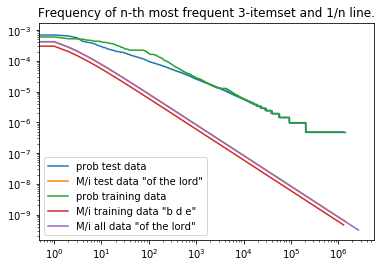

In [14]:
#create the trigram model
def createTrigramModel(instring):
    n = 3
    outset = instring#word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,3)
    probmodel = anoutcome
    sumofprob = 0
    
    previous1outcome = ngrams(outset,n-2)
    previous2outcome = ngrams(outset,n-1)
    
    for keyword in anoutcome:    
        listword = keyword.split()
        wordofinterest = listword[0]
        prob1 = previous1outcome[wordofinterest]/ totalpossible
           
        wordofinterest = listword[0] + " " + listword[1]
        prob2 = previous2outcome[wordofinterest]/previous1outcome[listword[0]] 
           
        wordofinterest = keyword
        probmodel[keyword] = prob1 * prob2 * anoutcome[wordofinterest]/ previous2outcome[listword[0]+ " " + listword[1]]
        sumofprob = sumofprob + probmodel[keyword]
        
    print(f"The sum of all the probabiities for trigrams needs to be 1 and it is {sumofprob}")
    return probmodel  

#create the trigram model
trigrammodel_test = createTrigramModel(tokens_test)
trigrammodel_training = createTrigramModel(tokens_training)


pandas.set_option("display.max_rows", 10)
tridataframe_test = pandas.DataFrame.from_dict(trigrammodel_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Trigram Prob. Model : ', len(tridataframe_test.index))
print(tridataframe_test)

pandas.set_option("display.max_rows", 10)
tridataframe_training = pandas.DataFrame.from_dict(trigrammodel_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Trigram Prob. Model : ', len(tridataframe_training.index))
print(tridataframe_training)

#Attempt to plot the trigram language model using first a Counter object
COUNT3_test = Counter(trigrammodel_test)
bigword3_test = getbigword(COUNT3_test)

COUNT3_training = Counter(trigrammodel_training)
bigword3_training = getbigword(COUNT3_training)

COUNT3_all = Counter(trigrammodel_training) + Counter(trigrammodel_test)
bigword3_all = getbigword(COUNT3_all)
        
print(f"the trigram of greatest freq  is: {bigword3_test}, {bigword3_training}, {bigword3_all} \n")
fig(3,bigword3_test,bigword3_training,bigword3_all,COUNT3_test,COUNT3_training,COUNT3_all)

The sum of all the probabiities of quadgrams needs to be 1 and it is 0.9999985952548408
The sum of all the probabiities of quadgrams needs to be 1 and it is 0.9999985428591107
Number of rows in Quadgram Prob. Model :  1872839
                                prob.
emma by jane austen      4.682514e-07
by jane austen volume    4.682514e-07
jane austen volume i     4.682514e-07
austen volume i chapter  4.682514e-07
volume i chapter i       4.682514e-07
...                               ...
now finally good bye     4.682514e-07
finally good bye and     4.682514e-07
good bye and hail        4.682514e-07
bye and hail my          4.682514e-07
and hail my fancy        4.682514e-07

[1872839 rows x 1 columns]
Number of rows in Quadgram Prob. Model :  1675231
                                              prob.
media multiplexity in connectivist     4.857109e-07
multiplexity in connectivist moocs     4.857109e-07
in connectivist moocs rafa             4.857109e-07
connectivist moocs rafa absar   

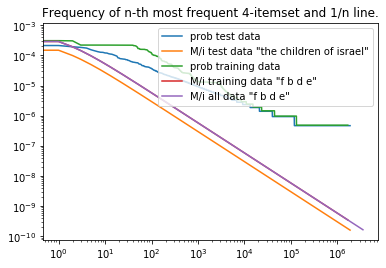

In [15]:
#create the quadgram model
def createQuadgramModel(instring):
    n = 4
    outset = instring#word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,n)
    probmodel = anoutcome   
    sumofprob = 0
   
    previous1outcome = ngrams(outset,n-3)
    previous2outcome = ngrams(outset,n-2)
    previous3outcome = ngrams(outset,n-1)
  
    for keyword in anoutcome:       
        listword = keyword.split()
        wordofinterest = listword[0]
        prob1 = previous1outcome[wordofinterest]/ totalpossible
           
        wordofinterest = listword[0] + " " + listword[1]
        prob2 = previous2outcome[wordofinterest]/previous1outcome[listword[0]] 
           
        wordofinterest = listword[0]+ " " + listword[1] + " " + listword[2]
        prob3 = previous3outcome[wordofinterest]/previous2outcome[listword[0] + " " + listword[1]]
           
        wordofinterest = keyword
        probmodel[keyword] = prob1 * prob2 * prob3 * anoutcome[wordofinterest]/ previous3outcome[listword[0]+ " " + listword[1] + " "+ listword[2]]
        sumofprob = sumofprob + probmodel[keyword]
           
    print(f"The sum of all the probabiities of quadgrams needs to be 1 and it is {sumofprob}")
    return probmodel  

#create the quadgram model
quadgrammodel_test = createQuadgramModel(tokens_test)
quadgrammodel_training = createQuadgramModel(tokens_training)

pandas.set_option("display.max_rows", 10)
quaddataframe_test = pandas.DataFrame.from_dict(quadgrammodel_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Quadgram Prob. Model : ', len(quaddataframe_test.index))
print(quaddataframe_test)

pandas.set_option("display.max_rows", 10)
quaddataframe_training = pandas.DataFrame.from_dict(quadgrammodel_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Quadgram Prob. Model : ', len(quaddataframe_training.index))
print(quaddataframe_training)
#Attempt to plot the trigram language model using first a Counter object

COUNT4_test = Counter(quadgrammodel_test)
COUNT4_training = Counter(quadgrammodel_training)
COUNT4_all = COUNT4_test + COUNT4_training

bigword4_test = getbigword(COUNT4_test)
bigword4_training = getbigword(COUNT4_training)
bigword4_all = getbigword(COUNT4_all)
        
print(f"the quadgram of greatest freq is: {bigword4_test}, {bigword4_training}, {bigword4_all} \n")
fig(4,bigword4_test,bigword4_training,bigword4_all,COUNT4_test,COUNT4_training,COUNT4_all)

In [7]:
#The team kept both ngrams method and newngram method for computing the unigrams, bigrams, trigrams and quadgrams
#smoothed models....output of newngram is a Counter obj and output of ngrams is a dictionary object...

#newngram outputs to files:
#the most common unigrams are set to unigramfile-smaller.dat
#the most common bigrams are set to bigramfile-smaller.dat
#the most common trigrams are set to trigramfile-smaller.dat
#the most common quadgrams are set to quadgramfile-smaller.dat

#newngram returns a count object
def newngram(toks, n):
    output = {}   
    for i in range(len(toks) - n + 1):
        g = ' '.join(toks[i:i+n])
        output.setdefault(g, 0)
        output[g] += 1
    COUNTS = Counter(output)
    if n == 1:
        #print(f"\n   The most common unigrams are: {(COUNTS.most_common(10))}")
        f=open("unigramfile-smaller.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(3000))) #trying to keep file size at about 50 k for this sample
        f.close()
    if n == 2:
        #print(f"\n   The most common bigrams are: {(COUNTS.most_common(10))}")
        f=open("bigramfile-smaller.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2700))) #trying to keep file size at about 50 k for this sample
        f.close()
    if n == 3:
        #print(f"\n The most common trigrams are: {(COUNTS.most_common(10))}")
        f=open("trigramfile-smaller.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2300))) #trying to keep file size at about 50 k for this sample
        f.close()
    if n == 4:
        #print(f"\n   The most common quadgrams are: {(COUNTS.most_common(10))}")
        f=open("quadgramfile-smaller.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2100))) #trying to keep file size at about 50 k for this sample
        f.close()
    
    return COUNTS

newunigrams_test = newngram(file_string_test, 1)
newuigrams_training = newngram(file_string_training, 2)
#print(newunigrams)
newbigrams_test = newngram(file_string_test, 2)
newbigrams_training = newngram(file_string_training, 2)
#print(newbigrams)
newtrigrams_test = newngram(file_string_test, 3)
newtrigrams_training = newngram(file_string_training, 3)
#print(newtrigrams)
newtrigrams_test = newngram(file_string_test, 4)
newtrigrams_training = newngram(file_string_training, 4)
#print(newquadgrams)


In [8]:
def createfileToken(inlist):
    filetokenlist=[]
    for list in inlist:
        file_token = word_tokenize(list)
        file_token = [w.lower() for w in file_token]
        filetokenlist.append(file_token)
    return filetokenlist
def createListDocCounter(filetokenlist,n):
    docfreqlist=[]
    for list in filetokenlist:        
        counter = Counter(newngram(list, n))
        docfreqlist.append(counter)
    return docfreqlist

In [9]:
#Generate file token
filetokenlist_test = createfileToken(file_string_test)
filetokenlist_training = createfileToken(file_string_training)

In [10]:
dfforuniperfile_test = createListDocCounter(filetokenlist_test,1)
firstunifile_test = dfforuniperfile_test[0]
dfforuniperfile_training = createListDocCounter(filetokenlist_training,1)
firstunifile_training = dfforuniperfile_training[0]

In [11]:
dfforbiperfile_test = createListDocCounter(filetokenlist_test,2)
firstbifile_test = dfforbiperfile_test[0]
dfforbiperfile_training = createListDocCounter(filetokenlist_training,2)
firstbifile_training = dfforbiperfile_training[0]

In [12]:
dffortriperfile_test = createListDocCounter(filetokenlist_test,3)
firsttrifile_test = dffortriperfile_test[0]
dffortriperfile_training = createListDocCounter(filetokenlist_training,3)
firsttrifile_training = dffortriperfile_training[0]

In [13]:
dfforquadperfile_test = createListDocCounter(filetokenlist_test,4)
firstquadfile_test = dfforquadperfile_test[0]
dfforquadperfile_training = createListDocCounter(filetokenlist_training,4)
firstquadfile_training = dfforquadperfile_training[0]

In [98]:
#Laplace smoothed unigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedUnigramModel(outset, dfperfilelist):
    n = 1   
    anoutcome = ngrams(outset,n)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
       
        
    #print(f"The laplaceprobmodel is \n {laplaceprobmodel}")
    print(f"The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    

The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is 1.0000000000001452
The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is 0.9999999999998622
Number of rows in Laplace Smoothed Unigram Prob. Model Test Data:  36550
             prob.
emma      0.000308
by        0.002964
jane      0.000112
austen    0.000007
volume    0.000017
...            ...
endowing  0.000007
delving   0.000007
germinal  0.000007
blither   0.000007
ushering  0.000007

[41065 rows x 1 columns]
Number of rows in Laplace Smoothed Unigram Prob. Model  Training:  36550
                 prob.
media         0.000066
multiplexity  0.000025
in            0.002358
connectivist  0.000028
moocs         0.000070
...                ...
takashi       0.000024
mousetracker  0.000024
aptel         0.000024
systemics     0.000024
jsci          0.000024

[36550 rows x 1 columns]


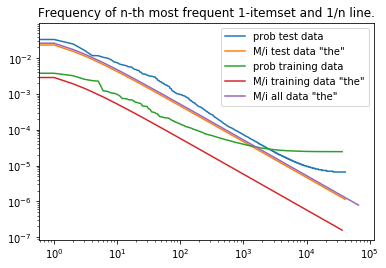

In [99]:
laplacesmoothunimodel_test = createLeplaceSmoothedUnigramModel(tokens_test, dfforuniperfile_test)
laplacesmoothunimodel_training = createLeplaceSmoothedUnigramModel(tokens_training, dfforuniperfile_training)

pandas.set_option("display.max_rows", 10)
laplacesmoothunidf_test = pandas.DataFrame.from_dict(laplacesmoothunimodel_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Unigram Prob. Model Test Data: ', len(laplacesmoothunidf_test.index))
print(laplacesmoothunidf_test)

pandas.set_option("display.max_rows", 10)
laplacesmoothunidf_training = pandas.DataFrame.from_dict(laplacesmoothunimodel_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Unigram Prob. Model  Training: ', len(laplacesmoothunidf_training.index))
print(laplacesmoothunidf_training)

#Attempt to plot the unigram language model using first a Counter object
COUNTLapSMOOTH_test = Counter(laplacesmoothunimodel_test)
bigword_test = getbigword(COUNTLapSMOOTH_test)

COUNTLapSMOOTH_training = Counter(laplacesmoothunimodel_training)
bigword_training = getbigword(COUNTLapSMOOTH_training)

COUNTLapSMOOTH_all =COUNTLapSMOOTH_test + COUNTLapSMOOTH_training
bigword_all = getbigword(COUNTLapSMOOTH_all)
fig(1,bigword_test,bigword_training,bigword_all,COUNTLapSMOOTH_test, COUNTLapSMOOTH_training, COUNTLapSMOOTH_all)

In [22]:
#Laplace smoothed bigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedBigramModel(outset, dfperfilelist):
    n = 2    
    anoutcome = ngrams(outset,n)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
     
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1    
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            if laplaceprobmodel.get(keyword) == None:
                laplaceprobmodel[keyword] = (count[keyword] + 1)/(filecount) 
            else:
               #print(keyword, count[keyword], filecount)
               laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
            #print(laplaceprobmodel[keyword], keyword)
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
        #print(sumoflaplaceprob)
    #print(f"The laplaeprobmodel is \n {laplaceprobmodel}")
    #print(f"The sum of all the probabiities needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    


In [23]:
laplacesmoothbimodel_test = createLeplaceSmoothedBigramModel(tokens_test, dfforbiperfile_test)
laplacesmoothbimodel_training = createLeplaceSmoothedBigramModel(tokens_training, dfforbiperfile_training)

Number of rows in Laplace Smoothed Bigram Prob. Model Test Data:  578067
                    prob.
emma by          2.000002
by jane          4.000002
jane austen      3.000002
austen volume    1.000002
volume i         1.000002
...                   ...
really undoing   1.000002
undoing turning  1.000002
turning so       1.000002
finally good     1.000002
hail my          1.000002

[578067 rows x 1 columns]
Number of rows in Laplace Smoothed Bigram Prob. Model  Training:  548110
                           prob.
media multiplexity      4.000002
multiplexity in         1.000002
in connectivist        19.000002
connectivist moocs     15.000002
moocs rafa              1.000002
...                          ...
problems journal        1.000002
on systemics            1.000002
systemics cybernetics   1.000002
informatics jsci        1.000002
jsci vol                1.000002

[548110 rows x 1 columns]


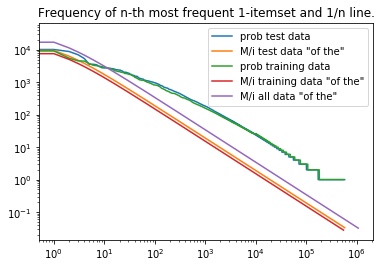

In [24]:

pandas.set_option("display.max_rows", 10)
laplacesmoothbidf_test = pandas.DataFrame.from_dict(laplacesmoothbimodel_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Bigram Prob. Model Test Data: ', len(laplacesmoothbidf_test.index))
print(laplacesmoothbidf_test)

pandas.set_option("display.max_rows", 10)
laplacesmoothbidf_training = pandas.DataFrame.from_dict(laplacesmoothbimodel_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Bigram Prob. Model  Training: ', len(laplacesmoothbidf_training.index))
print(laplacesmoothbidf_training)

#Attempt to plot the unigram language model using first a Counter object
COUNTLapSMOOTH_test = Counter(laplacesmoothbimodel_test)
bigword_test = getbigword(COUNTLapSMOOTH_test)

COUNTLapSMOOTH_training = Counter(laplacesmoothbimodel_training)
bigword_training = getbigword(COUNTLapSMOOTH_training)

COUNTLapSMOOTH_all =COUNTLapSMOOTH_test + COUNTLapSMOOTH_training
bigword_all = getbigword(COUNTLapSMOOTH_all)
fig(1,bigword_test,bigword_training,bigword_all,COUNTLapSMOOTH_test, COUNTLapSMOOTH_training, COUNTLapSMOOTH_all)

In [26]:
#Laplace smoothed trigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedTrigramModel(outset, dfperfilelist):
    n = 3   
    anoutcome = ngrams(outset,3)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = {}
    
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
         
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            if laplaceprobmodel.get(keyword) == None:
                laplaceprobmodel[keyword] = (count[keyword] + 1)/(filecount) 
            else:
            #print(keyword, count[keyword], filecount)
                laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
            #print(laplaceprobmodel[keyword], keyword)
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
        #print(sumoflaplaceprob)
    
    #print(f"The laplaeprobmodel is \n {laplaceprobmodel}")
    #print(f"The sum of all the trigram probabiities in the Laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel 

In [27]:
laplacesmoothtrimodel_test = createLeplaceSmoothedTrigramModel(tokens_test, dffortriperfile_test)

In [28]:
laplacesmoothtrimodel_training = createLeplaceSmoothedTrigramModel(tokens_training, dffortriperfile_training)

Number of rows in Laplace Smoothed Bigram Prob. Model Test Data:  1413343
                           prob.
emma by jane        6.890114e-07
by jane austen      7.615389e-07
jane austen volume  6.890114e-07
austen volume i     6.890114e-07
volume i chapter    6.890114e-07
...                          ...
now finally good    6.890114e-07
finally good bye    6.890114e-07
bye and hail        6.890114e-07
and hail my         6.890114e-07
hail my fancy       6.890114e-07

[1413343 rows x 1 columns]
Number of rows in Laplace Smoothed Bigram Prob. Model  Training:  1298271
                                     prob.
media multiplexity in         7.692851e-07
multiplexity in connectivist  7.692851e-07
in connectivist moocs         7.842066e-07
connectivist moocs rafa       7.692851e-07
moocs rafa absar              7.692851e-07
...                                    ...
systemics cybernetics and     7.692851e-07
cybernetics and informatics   7.692851e-07
and informatics jsci          7.692851e-0

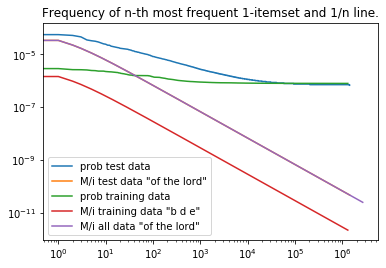

In [29]:
pandas.set_option("display.max_rows", 10)
laplacesmoothtridf_test = pandas.DataFrame.from_dict(laplacesmoothtrimodel_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Bigram Prob. Model Test Data: ', len(laplacesmoothtridf_test.index))
print(laplacesmoothtridf_test)

pandas.set_option("display.max_rows", 10)
laplacesmoothtridf_training = pandas.DataFrame.from_dict(laplacesmoothtrimodel_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Bigram Prob. Model  Training: ', len(laplacesmoothtridf_training.index))
print(laplacesmoothtridf_training)

#Attempt to plot the unigram language model using first a Counter object
COUNTLapSMOOTH_test = Counter(laplacesmoothtrimodel_test)
bigword_test = getbigword(COUNTLapSMOOTH_test)

COUNTLapSMOOTH_training = Counter(laplacesmoothtrimodel_training)
bigword_training = getbigword(COUNTLapSMOOTH_training)

COUNTLapSMOOTH_all =COUNTLapSMOOTH_test + COUNTLapSMOOTH_training
bigword_all = getbigword(COUNTLapSMOOTH_all)
fig(1,bigword_test,bigword_training,bigword_all,COUNTLapSMOOTH_test, COUNTLapSMOOTH_training, COUNTLapSMOOTH_all)

In [8]:
#Linear Interprolation model
import random
def linear_Interpolation(instring, n):
    #generate ngrams
    outset = instring#word_tokenize(instring)
    total = len(outset)
    anoutcome = []
    for i in range(1,n+1):
        anoutcome.append(ngrams(outset, i))  
    #print(f"anoutcome = {anoutcome}")
    #generate lamd
    k = 1
    lambd = []
    total_lambd = 0
    for i in range(1,n):
        lambd.append(random.uniform(0,k))
        k = k-lambd[i -1] 
        total_lambd += lambd[i-1]
    lambd.append(k)
    total_lambd +=k
    #print(f"lambd = {lambd}")
    
    #linear interpolation
    linear_interpolation = {}       
    for keyword in anoutcome[n-1]:
        grams = keyword.split(' ')  
        token = grams[len(grams) - 1]
        linear_interpolation.setdefault(keyword, lambd[0]*anoutcome[0][token]/total)
        #print(f"initial linear_interpolation = {linear_interpolation[keyword]}")
        for i in range(1,len(grams)):
            token = ' '.join(grams[i-1:len(grams)])
            #print(f"token: {token}")
            sub_grams = token.split(' ')
            sub_token =' '.join(sub_grams[0: len(sub_grams) - 1])
            #print(f"sub_token: {sub_token}")
            linear_interpolation[keyword] += lambd[i] * (anoutcome[len(grams) - i][token]/anoutcome[len(grams) - i -1][sub_token])
            #print(f"linear_interpolation[{keyword}]= {linear_interpolation[keyword]}")
       
    #print(f"linear_interpolation: {linear_interpolation}")
    return linear_interpolation

Number of rows in Linear Interpolation Unigram Prob. Model :  41065
                 prob.
emma      4.055057e-04
by        3.982010e-03
jane      1.418802e-04
austen    1.404754e-06
volume    1.498404e-05
...                ...
endowing  4.682514e-07
delving   4.682514e-07
germinal  4.682514e-07
blither   4.682514e-07
ushering  4.682514e-07

[41065 rows x 1 columns]
Number of rows in Linear Interpolation Unigram Prob. Model :  36550
                     prob.
media         3.798259e-04
multiplexity  4.857109e-06
in            2.151019e-02
connectivist  3.302834e-05
moocs         4.240256e-04
...                    ...
takashi       4.857109e-07
mousetracker  4.857109e-07
aptel         4.857109e-07
systemics     4.857109e-07
jsci          4.857109e-07

[36550 rows x 1 columns]
the linear interpolation of greatest freq in the smoothed unigram model is: the, the, the 



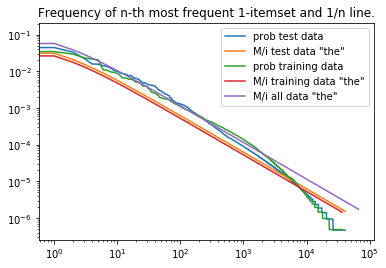

In [26]:
linear_inter_model_test = linear_Interpolation(tokens_test, 1)
linear_inter_model_training = linear_Interpolation(tokens_training, 1)

pandas.set_option("display.max_rows", 10)
linear_inter_frame_test = pandas.DataFrame.from_dict(linear_inter_model_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Unigram Prob. Model : ', len(linear_inter_frame_test.index))
print(linear_inter_frame_test)

pandas.set_option("display.max_rows", 10)
linear_inter_frame_training = pandas.DataFrame.from_dict(linear_inter_model_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Unigram Prob. Model : ', len(linear_inter_frame_training.index))
print(linear_inter_frame_training)


COUNTL_test = Counter(linear_inter_model_test)
COUNTL_training = Counter(linear_inter_model_training)
COUNTL_all = COUNTL_test + COUNTL_training
bigword_l_test = getbigword(COUNTL_test)
bigword_l_training = getbigword(COUNTL_training)
bigword_l_all = getbigword(COUNTL_all)

print(f"the linear interpolation of greatest freq in the smoothed unigram model is: {bigword_l_test}, {bigword_l_training}, {bigword_l_all} \n")
fig(1,bigword_l_test, bigword_l_training, bigword_l_all, COUNTL_test,COUNTL_training,COUNTL_all)

Number of rows in Linear Interpolation Bigram Prob. Model :  578067
                    prob.
emma by          0.002653
by jane          0.000403
jane austen      0.007866
austen volume    0.264817
volume i         0.027743
...                   ...
really undoing   0.001186
undoing turning  0.397244
turning so       0.004047
finally good     0.008914
hail my          0.010818

[578067 rows x 1 columns]
Number of rows in Linear Interpolation Bigram Prob. Model :  548110
                          prob.
media multiplexity     0.001302
multiplexity in        0.041429
in connectivist        0.000134
connectivist moocs     0.056295
moocs rafa             0.000292
...                         ...
problems journal       0.000862
on systemics           0.000016
systemics cybernetics  0.253775
informatics jsci       0.002672
jsci vol               0.253872

[548110 rows x 1 columns]
the linear interpolation of greatest freq in the smoothed bigram model is: delving the, descri the, straddle the 


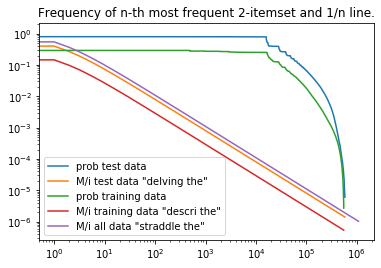

In [27]:
linear2_inter_model_test = linear_Interpolation(tokens_test, 2)
linear2_inter_model_training = linear_Interpolation(tokens_training, 2)

pandas.set_option("display.max_rows", 10)
linear2_inter_frame_test = pandas.DataFrame.from_dict(linear2_inter_model_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Bigram Prob. Model : ', len(linear2_inter_frame_test.index))
print(linear2_inter_frame_test)

pandas.set_option("display.max_rows", 10)
linear2_inter_frame_training = pandas.DataFrame.from_dict(linear2_inter_model_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Bigram Prob. Model : ', len(linear2_inter_frame_training.index))
print(linear2_inter_frame_training)


COUNTL2_test = Counter(linear2_inter_model_test)
COUNTL2_training = Counter(linear2_inter_model_training)
COUNTL2_all = COUNTL2_test + COUNTL2_training
bigword2_l_test = getbigword(COUNTL2_test)
bigword2_l_training = getbigword(COUNTL2_training)
bigword2_l_all = getbigword(COUNTL2_all)

print(f"the linear interpolation of greatest freq in the smoothed bigram model is: {bigword2_l_test}, {bigword2_l_training}, {bigword2_l_all} \n")
fig(2,bigword2_l_test, bigword2_l_training, bigword2_l_all, COUNTL2_test,COUNTL2_training,COUNTL2_all)

Number of rows in Linear Interpolation Trigram Prob. Model :  1413343
                       prob.
emma by jane        0.308562
by jane austen      0.464057
jane austen volume  0.251528
austen volume i     0.624708
volume i chapter    0.616968
...                      ...
now finally good    0.310291
finally good bye    0.619069
bye and hail        0.205665
and hail my         0.064598
hail my fancy       0.617120

[1413343 rows x 1 columns]
Number of rows in Linear Interpolation Trigram Prob. Model :  1298271
                                 prob.
media multiplexity in         0.099923
multiplexity in connectivist  0.204338
in connectivist moocs         0.196891
connectivist moocs rafa       0.014074
moocs rafa absar              0.608875
...                                ...
systemics cybernetics and     0.277989
cybernetics and informatics   0.102160
and informatics jsci          0.024676
informatics jsci vol          0.608927
jsci vol no                   0.374961

[1298271 rows x

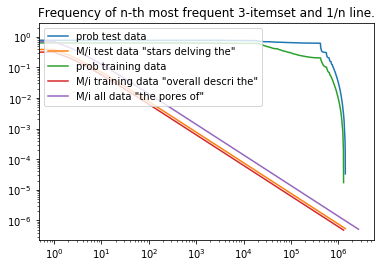

In [9]:
linear3_inter_model_test = linear_Interpolation(tokens_test, 3)
linear3_inter_model_training = linear_Interpolation(tokens_training, 3)

pandas.set_option("display.max_rows", 10)
linear3_inter_frame_test = pandas.DataFrame.from_dict(linear3_inter_model_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Trigram Prob. Model : ', len(linear3_inter_frame_test.index))
print(linear3_inter_frame_test)

pandas.set_option("display.max_rows", 10)
linear3_inter_frame_training = pandas.DataFrame.from_dict(linear3_inter_model_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Trigram Prob. Model : ', len(linear3_inter_frame_training.index))
print(linear3_inter_frame_training)


COUNTL3_test = Counter(linear3_inter_model_test)
COUNTL3_training = Counter(linear3_inter_model_training)
COUNTL3_all = COUNTL3_test + COUNTL3_training
bigword3_l_test = getbigword(COUNTL3_test)
bigword3_l_training = getbigword(COUNTL3_training)
bigword3_l_all = getbigword(COUNTL3_all)

print(f"the linear interpolation of greatest freq in the smoothed trigram model is: {bigword3_l_test}, {bigword3_l_training}, {bigword3_l_all} \n")
fig(3,bigword3_l_test, bigword3_l_training, bigword3_l_all, COUNTL3_test,COUNTL3_training,COUNTL3_all)

Number of rows in Linear Interpolation Quadgram Prob. Model :  1872839
                            prob.
emma by jane austen      0.221632
by jane austen volume    0.076602
jane austen volume i     0.234401
austen volume i chapter  0.223393
volume i chapter i       0.234406
...                           ...
now finally good bye     0.223391
finally good bye and     0.251660
good bye and hail        0.074453
bye and hail my          0.221004
and hail my fancy        0.223355

[1872839 rows x 1 columns]
Number of rows in Linear Interpolation Quadgram Prob. Model :  1675231
                                          prob.
media multiplexity in connectivist     0.194830
multiplexity in connectivist moocs     0.276612
in connectivist moocs rafa             0.015027
connectivist moocs rafa absar          0.903939
moocs rafa absar department            0.231649
...                                         ...
on systemics cybernetics and           0.306506
systemics cybernetics and informatics 

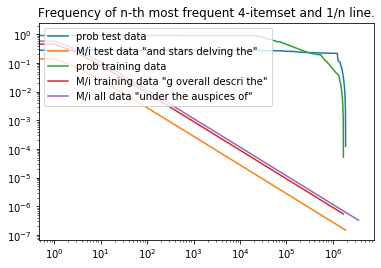

In [10]:
linear4_inter_model_test = linear_Interpolation(tokens_test, 4)
linear4_inter_model_training = linear_Interpolation(tokens_training, 4)

pandas.set_option("display.max_rows", 10)
linear4_inter_frame_test = pandas.DataFrame.from_dict(linear4_inter_model_test, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Quadgram Prob. Model : ', len(linear4_inter_frame_test.index))
print(linear4_inter_frame_test)

pandas.set_option("display.max_rows", 10)
linear4_inter_frame_training = pandas.DataFrame.from_dict(linear4_inter_model_training, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Quadgram Prob. Model : ', len(linear4_inter_frame_training.index))
print(linear4_inter_frame_training)


COUNTL4_test = Counter(linear4_inter_model_test)
COUNTL4_training = Counter(linear4_inter_model_training)
COUNTL4_all = COUNTL4_test + COUNTL4_training
bigword4_l_test = getbigword(COUNTL4_test)
bigword4_l_training = getbigword(COUNTL4_training)
bigword4_l_all = getbigword(COUNTL4_all)

print(f"the linear interpolation of greatest freq in the smoothed quadgram model is: {bigword4_l_test}, {bigword4_l_training}, {bigword4_l_all} \n")
fig(4,bigword4_l_test, bigword4_l_training, bigword4_l_all, COUNTL4_test,COUNTL4_training,COUNTL4_all)

In [11]:
#Linear Interprolation model smooth

def linear_Interpolation_smooth(instring, n):
    #generate ngrams
    outset = instring#word_tokenize(instring)
    total = len(outset)
    anoutcome = []
    for i in range(1,n+1):
        anoutcome.append(ngrams(outset, i))  
    #print(f"anoutcome = {anoutcome}")
    #generate lamd
    k = 1
    lambd = []
    total_lambd = 0
    for i in range(1,n):
        lambd.append(random.uniform(0,k))
        k = k-lambd[i -1] 
        total_lambd += lambd[i-1]
    lambd.append(k)
    total_lambd +=k
    #print(f"lambd = {lambd}")
    
    #linear interpolation
    linear_interpolation = {}       
    for keyword in anoutcome[n-1]:
        grams = keyword.split(' ')  
        token = grams[len(grams) - 1]
        linear_interpolation.setdefault(keyword, lambd[0]*(anoutcome[0][token]-0.5)/total)
        #print(f"initial linear_interpolation = {linear_interpolation[keyword]}")
        for i in range(1,len(grams)):
            token = ' '.join(grams[i-1:len(grams)])
            #print(f"token: {token}")
            sub_grams = token.split(' ')
            sub_token =' '.join(sub_grams[0: len(sub_grams) - 1])
            #print(f"sub_token: {sub_token}")
            linear_interpolation[keyword] += lambd[i] * ((anoutcome[len(grams) - i][token]-0.5)/anoutcome[len(grams) - i -1][sub_token])
            #print(f"linear_interpolation[{keyword}]= {linear_interpolation[keyword]}")
       
    #print(f"linear_interpolation: {linear_interpolation}")
    return linear_interpolation


Number of rows in Linear Interpolation Unigram Prob. Model :  41065
                 prob.
emma      4.052716e-04
by        3.981776e-03
jane      1.416460e-04
austen    1.170628e-06
volume    1.474992e-05
...                ...
endowing  2.341257e-07
delving   2.341257e-07
germinal  2.341257e-07
blither   2.341257e-07
ushering  2.341257e-07

[41065 rows x 1 columns]
Number of rows in Linear Interpolation Unigram Prob. Model :  36550
                     prob.
media         3.795830e-04
multiplexity  4.614253e-06
in            2.150995e-02
connectivist  3.278548e-05
moocs         4.237827e-04
...                    ...
takashi       2.428554e-07
mousetracker  2.428554e-07
aptel         2.428554e-07
systemics     2.428554e-07
jsci          2.428554e-07

[36550 rows x 1 columns]
the linear interpolation of greatest freq in the smoothed unigram model is: the, the, the 



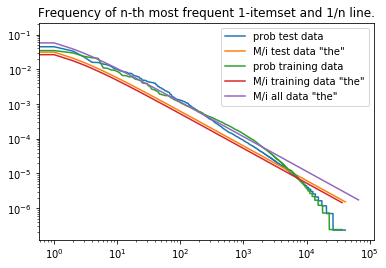

In [13]:
linear_inter_model_test_smooth = linear_Interpolation_smooth(tokens_test, 1)
linear_inter_model_training_smooth = linear_Interpolation_smooth(tokens_training, 1)

pandas.set_option("display.max_rows", 10)
linear_inter_frame_test = pandas.DataFrame.from_dict(linear_inter_model_test_smooth, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Unigram Prob. Model : ', len(linear_inter_frame_test.index))
print(linear_inter_frame_test)

pandas.set_option("display.max_rows", 10)
linear_inter_frame_training = pandas.DataFrame.from_dict(linear_inter_model_training_smooth, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Unigram Prob. Model : ', len(linear_inter_frame_training.index))
print(linear_inter_frame_training)


COUNTL_test = Counter(linear_inter_model_test_smooth)
COUNTL_training = Counter(linear_inter_model_training_smooth)
COUNTL_all = COUNTL_test + COUNTL_training
bigword_l_test = getbigword(COUNTL_test)
bigword_l_training = getbigword(COUNTL_training)
bigword_l_all = getbigword(COUNTL_all)

print(f"the linear interpolation of greatest freq in the smoothed unigram model is: {bigword_l_test}, {bigword_l_training}, {bigword_l_all} \n")
fig(1,bigword_l_test, bigword_l_training, bigword_l_all, COUNTL_test,COUNTL_training,COUNTL_all)

Number of rows in Linear Interpolation Bigram Prob. Model :  578067
                    prob.
emma by          0.002641
by jane          0.000303
jane austen      0.004919
austen volume    0.099368
volume i         0.015045
...                   ...
really undoing   0.000445
undoing turning  0.149089
turning so       0.002711
finally good     0.003788
hail my          0.005665

[578067 rows x 1 columns]
Number of rows in Linear Interpolation Bigram Prob. Model :  548110
                          prob.
media multiplexity     0.003197
multiplexity in        0.041853
in connectivist        0.000308
connectivist moocs     0.152381
moocs rafa             0.000409
...                         ...
problems journal       0.000695
on systemics           0.000022
systemics cybernetics  0.357024
informatics jsci       0.003758
jsci vol               0.357061

[548110 rows x 1 columns]
the linear interpolation of greatest freq in the smoothed bigram model is: meshach and, republish to, doesn t 



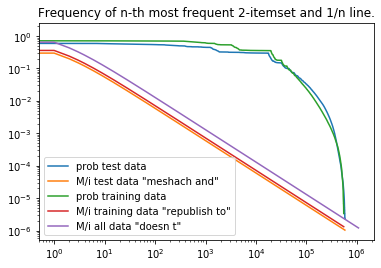

In [17]:
linear2_inter_model_test_smooth = linear_Interpolation_smooth(tokens_test, 2)
linear2_inter_model_training_smooth = linear_Interpolation_smooth(tokens_training, 2)

pandas.set_option("display.max_rows", 10)
linear2_inter_frame_test = pandas.DataFrame.from_dict(linear2_inter_model_test_smooth, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Bigram Prob. Model : ', len(linear2_inter_frame_test.index))
print(linear2_inter_frame_test)

pandas.set_option("display.max_rows", 10)
linear2_inter_frame_training = pandas.DataFrame.from_dict(linear2_inter_model_training_smooth, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Bigram Prob. Model : ', len(linear2_inter_frame_training.index))
print(linear2_inter_frame_training)


COUNTL2_test = Counter(linear2_inter_model_test_smooth)
COUNTL2_training = Counter(linear2_inter_model_training_smooth)
COUNTL2_all = COUNTL2_test + COUNTL2_training
bigword2_l_test = getbigword(COUNTL2_test)
bigword2_l_training = getbigword(COUNTL2_training)
bigword2_l_all = getbigword(COUNTL2_all)

print(f"the linear interpolation of greatest freq in the smoothed bigram model is: {bigword2_l_test}, {bigword2_l_training}, {bigword2_l_all} \n")
fig(2,bigword2_l_test, bigword2_l_training, bigword2_l_all, COUNTL2_test,COUNTL2_training,COUNTL2_all)

Number of rows in Linear Interpolation Trigram Prob. Model :  1413343
                       prob.
emma by jane        0.075699
by jane austen      0.116817
jane austen volume  0.172527
austen volume i     0.169218
volume i chapter    0.151005
...                      ...
now finally good    0.080098
finally good bye    0.156622
bye and hail        0.050362
and hail my         0.021989
hail my fancy       0.151418

[1413343 rows x 1 columns]
Number of rows in Linear Interpolation Trigram Prob. Model :  1298271
                                 prob.
media multiplexity in         0.031476
multiplexity in connectivist  0.039787
in connectivist moocs         0.023806
connectivist moocs rafa       0.002664
moocs rafa absar              0.051005
...                                ...
systemics cybernetics and     0.069561
cybernetics and informatics   0.019921
and informatics jsci          0.004094
informatics jsci vol          0.051132
jsci vol no                   0.045094

[1298271 rows x

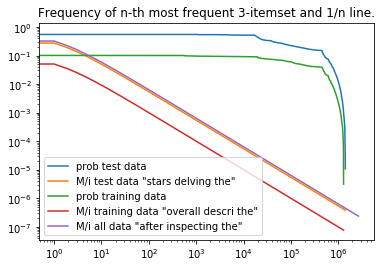

In [18]:
linear3_inter_model_test_smooth = linear_Interpolation(tokens_test, 3)
linear3_inter_model_training_smooth = linear_Interpolation(tokens_training, 3)

pandas.set_option("display.max_rows", 10)
linear3_inter_frame_test = pandas.DataFrame.from_dict(linear3_inter_model_test_smooth, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Trigram Prob. Model : ', len(linear3_inter_frame_test.index))
print(linear3_inter_frame_test)

pandas.set_option("display.max_rows", 10)
linear3_inter_frame_training = pandas.DataFrame.from_dict(linear3_inter_model_training_smooth, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Trigram Prob. Model : ', len(linear3_inter_frame_training.index))
print(linear3_inter_frame_training)


COUNTL3_test = Counter(linear3_inter_model_test_smooth)
COUNTL3_training = Counter(linear3_inter_model_training_smooth)
COUNTL3_all = COUNTL3_test + COUNTL3_training
bigword3_l_test = getbigword(COUNTL3_test)
bigword3_l_training = getbigword(COUNTL3_training)
bigword3_l_all = getbigword(COUNTL3_all)

print(f"the linear interpolation of greatest freq in the smoothed trigram model is: {bigword3_l_test}, {bigword3_l_training}, {bigword3_l_all} \n")
fig(3,bigword3_l_test, bigword3_l_training, bigword3_l_all, COUNTL3_test,COUNTL3_training,COUNTL3_all)

Number of rows in Linear Interpolation Quadgram Prob. Model :  1872839
                            prob.
emma by jane austen      0.801847
by jane austen volume    0.282752
jane austen volume i     0.850290
austen volume i chapter  0.848157
volume i chapter i       0.850290
...                           ...
now finally good bye     0.848139
finally good bye and     0.682112
good bye and hail        0.282717
bye and hail my          0.682244
and hail my fancy        0.848148

[1872839 rows x 1 columns]
Number of rows in Linear Interpolation Quadgram Prob. Model :  1675231
                                          prob.
media multiplexity in connectivist     0.365927
multiplexity in connectivist moocs     0.366614
in connectivist moocs rafa             0.035655
connectivist moocs rafa absar          0.433270
moocs rafa absar department            0.359194
...                                         ...
on systemics cybernetics and           0.393015
systemics cybernetics and informatics 

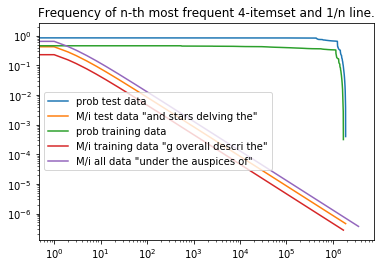

In [19]:
linear4_inter_model_test_smooth = linear_Interpolation(tokens_test, 4)
linear4_inter_model_training_smooth = linear_Interpolation(tokens_training, 4)

pandas.set_option("display.max_rows", 10)
linear4_inter_frame_test = pandas.DataFrame.from_dict(linear4_inter_model_test_smooth, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Quadgram Prob. Model : ', len(linear4_inter_frame_test.index))
print(linear4_inter_frame_test)

pandas.set_option("display.max_rows", 10)
linear4_inter_frame_training = pandas.DataFrame.from_dict(linear4_inter_model_training_smooth, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Interpolation Quadgram Prob. Model : ', len(linear4_inter_frame_training.index))
print(linear4_inter_frame_training)


COUNTL4_test = Counter(linear4_inter_model_test_smooth)
COUNTL4_training = Counter(linear4_inter_model_training_smooth)
COUNTL4_all = COUNTL4_test + COUNTL4_training
bigword4_l_test = getbigword(COUNTL4_test)
bigword4_l_training = getbigword(COUNTL4_training)
bigword4_l_all = getbigword(COUNTL4_all)

print(f"the linear interpolation of greatest freq in the smoothed quadgram model is: {bigword4_l_test}, {bigword4_l_training}, {bigword4_l_all} \n")
fig(4,bigword4_l_test, bigword4_l_training, bigword4_l_all, COUNTL4_test,COUNTL4_training,COUNTL4_all)